In [ ]:
# Import Dependencies
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from natsort import natsorted, order_by_index, index_natsorted
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [ ]:
# To use automation feature tools (feature engineering) - results were poor, not used in final solution/model
# !pip install "featuretools[complete]"
import featuretools as ft

In [ ]:
# mount drive to get files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# read in the datasets
client_train = pd.read_csv('/content/drive/Shareddrives/CMPE 255/Colab Notebooks/Project Data/client_train.csv')
client_test = pd.read_csv('/content/drive/Shareddrives/CMPE 255/Colab Notebooks/Project Data/client_test.csv')

invoice_train = pd.read_csv('/content/drive/Shareddrives/CMPE 255/Colab Notebooks/Project Data/invoice_train.csv')
invoice_test = pd.read_csv('/content/drive/Shareddrives/CMPE 255/Colab Notebooks/Project Data/invoice_test.csv')

sample_submission = pd.read_csv('/content/drive/Shareddrives/CMPE 255/Colab Notebooks/Project Data/SampleSubmission (2).csv',low_memory=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Exploratory Data Analysis

In [ ]:
#length of dataset
client_train_len = len(client_train.index);
client_test_len = len(client_test.index);
invoice_train_len = len(invoice_train.index);
invoice_test_len = len(invoice_test.index);

client_train_fraud_len = len(client_train[client_train['target'] == 1.0].index);
client_train_non_fraud_len = client_train_len - client_train_fraud_len;

print('Client Train Data Length: ' + str(client_train_len));
print('Client Train - Number of Clients that Committed Fraud: ' + str(client_train_fraud_len));
print('Client Train - Number of Clients that Did Not Commit Fraud: ' +str(client_train_non_fraud_len))
print('Invoice Train Data Length: ' + str(invoice_train_len));

print('Client Test Data Length: ' + str(client_test_len));
print('Invoice Test Data Length: ' + str(invoice_test_len));

client_train_where_fraud = client_train[client_train['target'] == 1.0];
client_train_where_not_fraud = client_train[client_train['target'] != 1.0];


Client Train Data Length: 135493
Client Train - Number of Clients that Committed Fraud: 7566
Client Train - Number of Clients that Did Not Commit Fraud: 127927
Invoice Train Data Length: 4476749
Client Test Data Length: 58069
Invoice Test Data Length: 1939730


In [ ]:
#Client Dataset

#Client_id: Unique id for client
#District: District where the client is
#Client_catg: Category client belongs to
#Region: Area where the client is
#Creation_date: Date client joined
#Target: fraud:1 , not fraud: 0
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [ ]:
client_test.head()

,disrict,client_id,client_catg,region,creation_date
0,62,test_Client_0,11,307,28/05/2002
1,69,test_Client_1,11,103,06/08/2009
2,62,test_Client_10,11,310,07/04/2004
3,60,test_Client_100,11,101,08/10/1992
4,62,test_Client_1000,11,301,21/07/1977


In [ ]:
#Invoice Dataset

#Client_id: Unique id for the client
#Invoice_date: Date of the invoice
#Tarif_type: Type of tax
#Counter_number:
#Counter_statue: takes up to 5 values such as working fine, not working, on hold statue, ect
#Counter_code:
#Reading_remarque: notes that the STEG agent takes during his visit to the client (e.g: If the counter shows something wrong, the agent gives a bad score)
#Counter_coefficient: An additional coefficient to be added when standard consumption is exceeded
#Consommation_level_1: Consumption_level_1
#Consommation_level_2: Consumption_level_2
#Consommation_level_3: Consumption_level_3
#Consommation_level_4: Consumption_level_4
#Old_index: Old index
#New_index: New index
#Months_number: Month number
#Counter_type: Type of counter
invoice_train.head()


,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [ ]:
invoice_test.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,test_Client_0,2018-03-16,11,651208,0,203,8,1,755,0,0,0,19145,19900,8,ELEC
1,test_Client_0,2014-03-21,11,651208,0,203,8,1,1067,0,0,0,13725,14792,8,ELEC
2,test_Client_0,2014-07-17,11,651208,0,203,8,1,0,0,0,0,14792,14792,4,ELEC
3,test_Client_0,2015-07-13,11,651208,0,203,9,1,410,0,0,0,16122,16532,4,ELEC
4,test_Client_0,2016-07-19,11,651208,0,203,9,1,412,0,0,0,17471,17883,4,ELEC


In [ ]:
# Unique values & count in district feature
client_train.disrict.value_counts()

62    40353
69    34231
60    31922
63    28987
Name: disrict, dtype: int64

In [ ]:
# different values of client category feature
client_train.client_catg.value_counts()

11    131494
12      2321
51      1678
Name: client_catg, dtype: int64

In [ ]:
# different values of region feature
client_train.region.value_counts()

101    33770
104    12865
311    12406
107     9998
301     9544
103     8964
306     6044
303     5982
310     4851
312     4379
302     4311
304     3828
309     3669
307     3376
305     2716
313     2076
371     2065
105     1645
308      841
106      706
372      644
379      583
399      175
206       53
199        2
Name: region, dtype: int64

In [ ]:
# unique values for every feature in invoice dataset
for col in invoice_train.columns:
    print(f"{col}: {invoice_train[col].nunique()}")

client_id: 135493
invoice_date: 8275
tarif_type: 17
counter_number: 201893
counter_statue: 16
counter_code: 42
reading_remarque: 8
counter_coefficient: 16
consommation_level_1: 8295
consommation_level_2: 12576
consommation_level_3: 2253
consommation_level_4: 12075
old_index: 155648
new_index: 157980
months_number: 1370
counter_type: 2


In [ ]:
#unique values of every feature in client dataset
for col in client_train.columns:
    print(f"{col}: {client_train[col].nunique()}")

disrict: 4
client_id: 135493
client_catg: 3
region: 25
creation_date: 8088
target: 2


In [ ]:
# number of fraud vs non fraud
client_train.target.value_counts()

0.0    127927
1.0      7566
Name: target, dtype: int64

[Text(0.5, 1.0, 'Client Category effect on Fraud')]

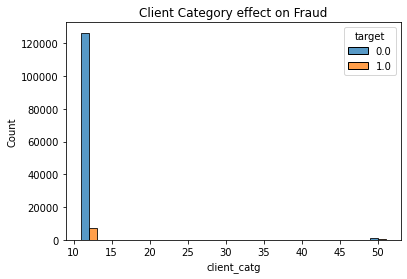

In [ ]:
# check client category effect on fraud
sbn.histplot(data = client_train, x = "client_catg", hue = "target", multiple = "dodge").set(title='Client Category effect on Fraud')


[Text(0.5, 1.0, 'District effect on Fraud')]

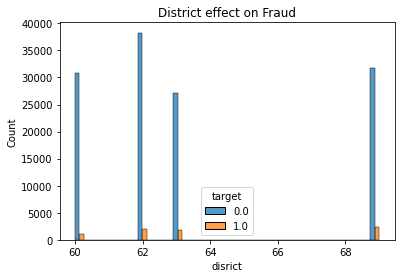

In [ ]:
#check district effect on fraud
sbn.histplot(data = client_train, x = "disrict", hue = "target", multiple = "dodge").set(title='District effect on Fraud')

[Text(0.5, 1.0, 'Region effect on Fraud')]

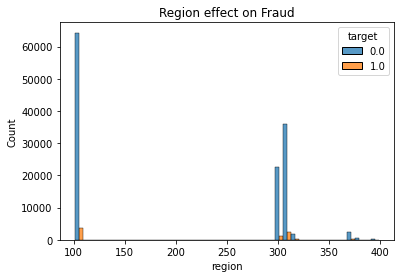

In [ ]:
#check region effect on fraud
sbn.histplot(data = client_train, x = "region", hue = "target", multiple = "dodge").set(title='Region effect on Fraud')

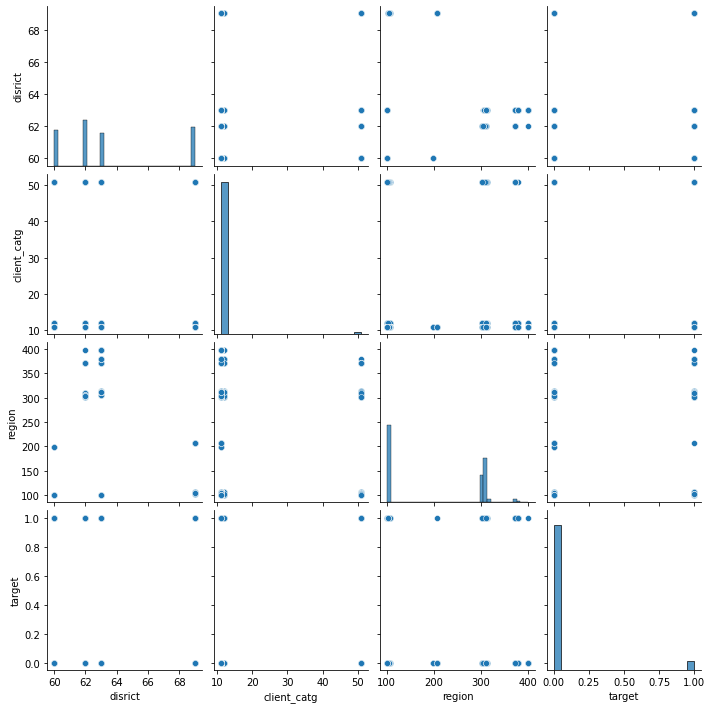

In [ ]:
# Client Dataset PairPlot
sbn.pairplot(data = client_train)

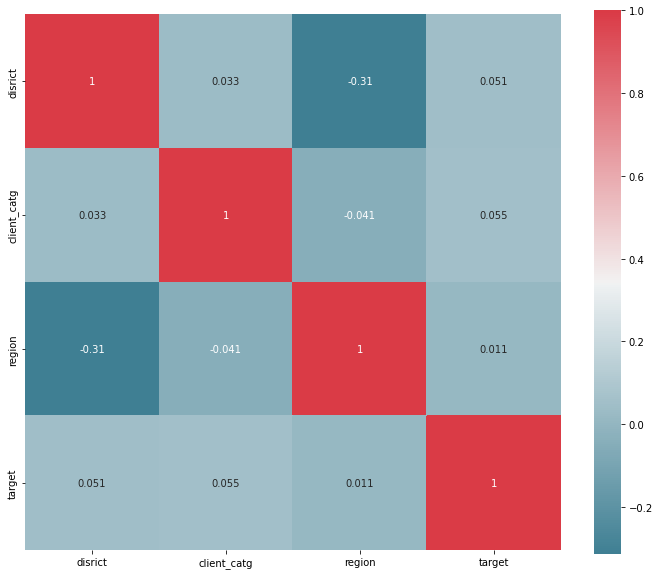

In [ ]:
# Client Dataset Cov Heat Map
f, ax = plt.subplots(figsize=(12, 10))
sbn.heatmap(client_train.corr(), annot=True,
            cmap=sbn.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax)

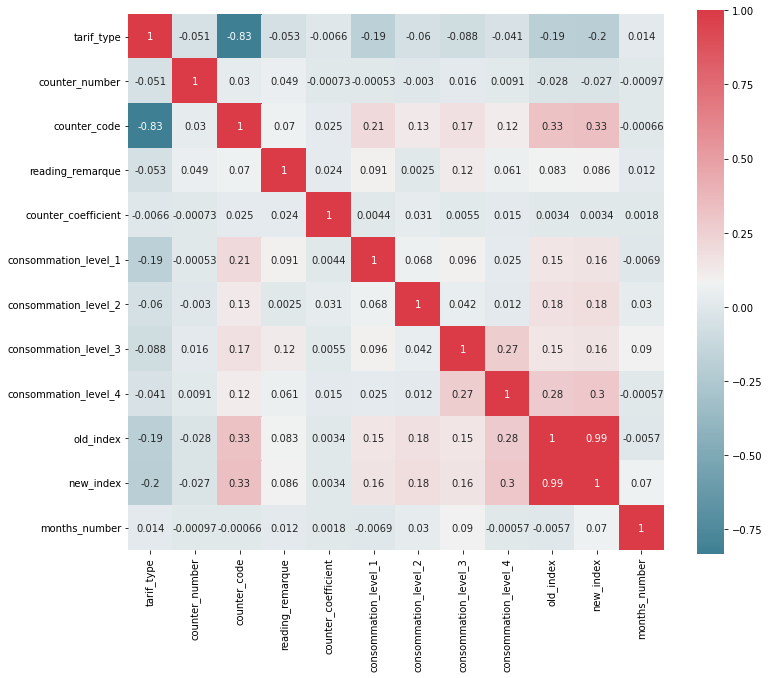

In [ ]:
# Invoice Dataset Cov HeatMap
f, ax = plt.subplots(figsize=(12, 10))
sbn.heatmap(invoice_train.corr(), annot=True,
            cmap=sbn.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax)

# Best Performing Model

### Preprocessing

In [ ]:
# Working with invoice dataset
def preprocessing(invoice):
  # Categorizing counter type feature into binary value
  invoice.counter_type = invoice.counter_type.map({"GAZ":0,"ELEC":1})
  # Remvoing strings from counter statue
  invoice.counter_statue = invoice.counter_statue.map({'A':0,'0':0,'1':1,'2':2,'3':3,'4':4,'5':5})
  return invoice

In [ ]:
invoice_train = preprocessing(invoice_train)
invoice_test = preprocessing(invoice_test)

In [ ]:
# Creating new dataframe by aggregating features in invoice dataset
def new_invoice(invoice, feature_list):
  
  # take aggregated stats of features in invoice dataset to form the new invoice dataset
  invoice_new = invoice.groupby('client_id')[feature_list].agg(['mean', 'median', 'min', 'max', 'var', 'std'])
  
  #create new column names for the newly created dataset
  invoice_new.columns = ['_'.join(col).strip() for col in invoice_new.columns.values]
  invoice_new.reset_index(inplace=True)

  return invoice_new

# Feature's from invoice dataset to compute aggregation on
feature_list = [
 'tarif_type',
 'counter_number',
 #'counter_statue',
 'counter_code',
 'reading_remarque',
 'counter_coefficient',
 'consommation_level_1',
 'consommation_level_2',
 'consommation_level_3',
 'consommation_level_4',
 'old_index',
 'new_index',
 'months_number',
 'counter_type',
]

In [ ]:
invoice_train_new = new_invoice(invoice_train, feature_list)
invoice_test_new = new_invoice(invoice_test, feature_list)

In [ ]:
invoice_train_new.head()

,client_id,tarif_type_mean,tarif_type_median,tarif_type_min,tarif_type_max,tarif_type_var,tarif_type_std,counter_number_mean,counter_number_median,counter_number_min,counter_number_max,counter_number_var,counter_number_std,counter_code_mean,counter_code_median,counter_code_min,counter_code_max,counter_code_var,counter_code_std,reading_remarque_mean,reading_remarque_median,reading_remarque_min,reading_remarque_max,reading_remarque_var,reading_remarque_std,counter_coefficient_mean,counter_coefficient_median,counter_coefficient_min,counter_coefficient_max,counter_coefficient_var,counter_coefficient_std,consommation_level_1_mean,consommation_level_1_median,consommation_level_1_min,consommation_level_1_max,consommation_level_1_var,consommation_level_1_std,consommation_level_2_mean,consommation_level_2_median,consommation_level_2_min,consommation_level_2_max,consommation_level_2_var,consommation_level_2_std,consommation_level_3_mean,consommation_level_3_median,consommation_level_3_min,consommation_level_3_max,consommation_level_3_var,consommation_level_3_std,consommation_level_4_mean,consommation_level_4_median,consommation_level_4_min,consommation_level_4_max,consommation_level_4_var,consommation_level_4_std,old_index_mean,old_index_median,old_index_min,old_index_max,old_index_var,old_index_std,new_index_mean,new_index_median,new_index_min,new_index_max,new_index_var,new_index_std,months_number_mean,months_number_median,months_number_min,months_number_max,months_number_var,months_number_std,counter_type_mean,counter_type_median,counter_type_min,counter_type_max,counter_type_var,counter_type_std
0,train_Client_0,11.0,11.0,11,11,0.0,0.0,1335667.0,1335667.0,1335667,1335667,0.0,0.0,203.685714,203.0,203,207,2.339496,1.529541,6.971429,6.0,6,9,1.557983,1.248192,1.0,1.0,1,1,0.0,0.0,352.400000,267.0,38,1200,96313.070588,310.343472,10.571429,0.0,0,186,1898.252101,43.568935,0.000000,0.0,0,0,0.000000,0.000000,0.000000,0.0,0,0,0.000000,0.000000,9444.542857,7770.0,3685,16493,2.050047e+07,4527.744415,9807.514286,9156.0,3809,17078,2.097335e+07,4579.666655,4.628571,4.0,2,12,4.416807,2.101620,1.0,1.0,1,1,0.0,0.0
1,train_Client_1,11.0,11.0,11,11,0.0,0.0,678902.0,678902.0,678902,678902,0.0,0.0,203.000000,203.0,203,203,0.000000,0.000000,7.216216,6.0,6,9,1.896396,1.377097,1.0,1.0,1,1,0.0,0.0,557.540541,520.0,190,1207,39178.644144,197.935960,0.000000,0.0,0,0,0.000000,0.000000,0.000000,0.0,0,0,0.000000,0.000000,0.000000,0.0,0,0,0.000000,0.000000,14330.756757,14232.0,4110,23940,3.750492e+07,6124.126094,14888.297297,14680.0,4661,25022,3.745102e+07,6119.723768,4.324324,4.0,2,8,1.891892,1.375461,1.0,1.0,1,1,0.0,0.0
2,train_Client_10,11.0,11.0,11,11,0.0,0.0,572765.0,572765.0,572765,572765,0.0,0.0,203.222222,203.0,203,207,0.888889,0.942809,7.055556,6.0,6,9,1.584967,1.258955,1.0,1.0,1,1,0.0,0.0,798.611111,655.5,188,2400,264032.957516,513.841374,37.888889,0.0,0,682,25840.222222,160.748942,0.000000,0.0,0,0,0.000000,0.000000,0.000000,0.0,0,0,0.000000,0.000000,32873.000000,31469.0,25515,41532,2.827241e+07,5317.180865,33709.500000,32158.5,25974,44614,3.072740e+07,5543.230331,6.444444,4.0,4,12,11.555556,3.399346,1.0,1.0,1,1,0.0,0.0
3,train_Client_100,11.0,11.0,11,11,0.0,0.0,2078.0,2078.0,2078,2078,0.0,0.0,413.000000,413.0,413,413,0.000000,0.000000,6.150000,6.0,6,9,0.450000,0.670820,1.0,1.0,1,1,0.0,0.0,1.200000,0.0,0,15,13.010526,3.607011,0.000000,0.0,0,0,0.000000,0.000000,0.000000,0.0,0,0,0.000000,0.000000,0.000000,0.0,0,0,0.000000,0.000000,94.150000,91.0,90,99,1.697632e+01,4.120232,95.350000,94.5,90,114,3.529211e+01,5.940716,4.200000,4.0,4,6,0.378947,0.615587,1.0,1.0,1,1,0.0,0.0
4,train_Client_1000,11.0,11.0,11,11,0.0,0.0,19575.0,19575.0,19575,19575,0.0,0.0,207.000000,207.0,207,207,0.000000,0.000000,8.857143,9.0,8,9,0.131868,0.363137,1.0,1.0,1,1,0.0,0.0,663.714286,770.0,124,800,50549.142857,224.831365,104.857143,0.0,0,400,27940.901099,167.155320,117.357143,0.0,0,800,83771.631868,289.433294,36.714286,0.0,0,382,11113.604396,105.421081,6900.428571,6989.5,0,13337,2.23928

In [ ]:
invoice_test_new.head()

,client_id,tarif_type_mean,tarif_type_median,tarif_type_min,tarif_type_max,tarif_type_var,tarif_type_std,counter_number_mean,counter_number_median,counter_number_min,counter_number_max,counter_number_var,counter_number_std,counter_code_mean,counter_code_median,counter_code_min,counter_code_max,counter_code_var,counter_code_std,reading_remarque_mean,reading_remarque_median,reading_remarque_min,reading_remarque_max,reading_remarque_var,reading_remarque_std,counter_coefficient_mean,counter_coefficient_median,counter_coefficient_min,counter_coefficient_max,counter_coefficient_var,counter_coefficient_std,consommation_level_1_mean,consommation_level_1_median,consommation_level_1_min,consommation_level_1_max,consommation_level_1_var,consommation_level_1_std,consommation_level_2_mean,consommation_level_2_median,consommation_level_2_min,consommation_level_2_max,consommation_level_2_var,consommation_level_2_std,consommation_level_3_mean,consommation_level_3_median,consommation_level_3_min,consommation_level_3_max,consommation_level_3_var,consommation_level_3_std,consommation_level_4_mean,consommation_level_4_median,consommation_level_4_min,consommation_level_4_max,consommation_level_4_var,consommation_level_4_std,old_index_mean,old_index_median,old_index_min,old_index_max,old_index_var,old_index_std,new_index_mean,new_index_median,new_index_min,new_index_max,new_index_var,new_index_std,months_number_mean,months_number_median,months_number_min,months_number_max,months_number_var,months_number_std,counter_type_mean,counter_type_median,counter_type_min,counter_type_max,counter_type_var,counter_type_std
0,test_Client_0,11.000000,11.0,11,11,0.000000,0.000000,6.512080e+05,651208.0,651208,651208,0.000000e+00,0.000000e+00,203.000000,203.0,203,203,0.000000,0.000000,6.810811,6.0,6,9,1.490991,1.221061,1.0,1.0,1,1,0.0,0.0,488.135135,415.0,0,1090,53079.064565,230.388942,3.243243,0.0,0,120,389.189189,19.727878,0.000000,0.0,0,0,0.000000,0.000000,0.000000,0.0,0,0,0.000000e+00,0.000000,11389.837838,10940.0,3057,21348,2.917127e+07,5401.043096,11881.216216,11402.0,3383,21677,2.975780e+07,5455.070893,4.378378,4.0,2,8,1.741742,1.319751,1.000000,1.0,1,1,0.000000,0.000000
1,test_Client_1,11.000000,11.0,11,11,0.000000,0.000000,1.747600e+05,174760.0,174760,174760,0.000000e+00,0.000000e+00,433.000000,433.0,433,433,0.000000,0.000000,7.636364,8.0,6,9,1.480519,1.216766,1.0,1.0,1,1,0.0,0.0,1091.409091,800.0,11,3600,546395.110390,739.185437,843.136364,400.0,0,4053,974038.504329,986.933891,182.318182,0.0,0,1144,100244.322511,316.613838,586.318182,0.0,0,12899,7.562918e+06,2750.076040,29380.772727,34413.0,7,55213,3.111140e+08,17638.422718,32083.954545,36915.5,800,57083,3.116216e+08,17652.806615,4.545455,4.0,2,12,5.783550,2.404901,1.000000,1.0,1,1,0.000000,0.000000
2,test_Client_10,23.540541,11.0,11,40,209.238060,14.465063,3.468089e+06,799814.0,799814,6970199,9.472600e+12,3.077759e+06,119.648649,207.0,5,207,10151.902258,100.756649,7.459459,7.0,6,9,2.196964,1.482216,1.0,1.0,1,1,0.0,0.0,554.040541,690.0,0,1200,120253.518882,346.775891,37.364865,0.0,0,400,9127.166420,95.536205,15.743243,0.0,0,800,10340.878378,101.690110,0.162162,0.0,0,12,1.945946e+00,1.394972,11774.054054,7991.0,0,37461,1.207225e+08,10987.377541,12381.364865,8197.0,41,39026,1.276873e+08,11299.881222,4.000000,4.0,4,4,0.000000,0.000000,0.567568,1.0,0,1,0.248797,0.498795
3,test_Client_100,25.500000,25.5,11,40,215.641026,14.684721,5.866505e+05,586650.5,108943,1064358,2.340559e+11,4.837932e+05,104.000000,104.0,5,203,10052.307692,100.261197,6.575000,6.0,6,9,1.071154,1.034966,1.0,1.0,1,1,0.0,0.0,244.350000,139.0,0,721,61134.130769,247.253171,0.000000,0.0,0,0,0.000000,0.000000,0.000000,0.0,0,0,0.000000,0.000000,0.000000,0.0,0,0,0.000000e+00,0.000000,13623.725000,11795.5,148,31354,1.753602e+08,13242.361986,13868.075000,11949.0,240,31525,1.807456e+08,13444.166323,3.900000,4.0,2,4,0.194872,0.441443,0.500000,0.5,0,1,0.256410,0.506370
4,test_Client_1000,20.849057,11.0,11,40,192.246009,13.865281,1.614115e+06,420950.0,481

In [ ]:
# Combine the client dataset with the newly created invoice datasets above
combined_train = pd.merge(client_train, invoice_train_new, on='client_id', how='left')
combined_test = pd.merge(client_test, invoice_test_new, on='client_id', how='left')

In [ ]:
combined_train.head()

,disrict,client_id,client_catg,region,creation_date,target,tarif_type_mean,tarif_type_median,tarif_type_min,tarif_type_max,tarif_type_var,tarif_type_std,counter_number_mean,counter_number_median,counter_number_min,counter_number_max,counter_number_var,counter_number_std,counter_code_mean,counter_code_median,counter_code_min,counter_code_max,counter_code_var,counter_code_std,reading_remarque_mean,reading_remarque_median,reading_remarque_min,reading_remarque_max,reading_remarque_var,reading_remarque_std,counter_coefficient_mean,counter_coefficient_median,counter_coefficient_min,counter_coefficient_max,counter_coefficient_var,counter_coefficient_std,consommation_level_1_mean,consommation_level_1_median,consommation_level_1_min,consommation_level_1_max,...,consommation_level_2_min,consommation_level_2_max,consommation_level_2_var,consommation_level_2_std,consommation_level_3_mean,consommation_level_3_median,consommation_level_3_min,consommation_level_3_max,consommation_level_3_var,consommation_level_3_std,consommation_level_4_mean,consommation_level_4_median,consommation_level_4_min,consommation_level_4_max,consommation_level_4_var,consommation_level_4_std,old_index_mean,old_index_median,old_index_min,old_index_max,old_index_var,old_index_std,new_index_mean,new_index_median,new_index_min,new_index_max,new_index_var,new_index_std,months_number_mean,months_number_median,months_number_min,months_number_max,months_number_var,months_number_std,counter_type_mean,counter_type_median,counter_type_min,counter_type_max,counter_type_var,counter_type_std
0,60,train_Client_0,11,101,31/12/1994,0.0,11.0,11.0,11,11,0.0,0.0,1335667.0,1335667.0,1335667,1335667,0.0,0.0,203.685714,203.0,203,207,2.339496,1.529541,6.971429,6.0,6,9,1.557983,1.248192,1.0,1.0,1,1,0.0,0.0,352.400000,267.0,38,1200,...,0,186,1898.252101,43.568935,0.000000,0.0,0,0,0.000000,0.000000,0.000000,0.0,0,0,0.000000,0.000000,9444.542857,7770.0,3685,16493,2.050047e+07,4527.744415,9807.514286,9156.0,3809,17078,2.097335e+07,4579.666655,4.628571,4.0,2,12,4.416807,2.101620,1.0,1.0,1,1,0.0,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0,11.0,11.0,11,11,0.0,0.0,678902.0,678902.0,678902,678902,0.0,0.0,203.000000,203.0,203,203,0.000000,0.000000,7.216216,6.0,6,9,1.896396,1.377097,1.0,1.0,1,1,0.0,0.0,557.540541,520.0,190,1207,...,0,0,0.000000,0.000000,0.000000,0.0,0,0,0.000000,0.000000,0.000000,0.0,0,0,0.000000,0.000000,14330.756757,14232.0,4110,23940,3.750492e+07,6124.126094,14888.297297,14680.0,4661,25022,3.745102e+07,6119.723768,4.324324,4.0,2,8,1.891892,1.375461,1.0,1.0,1,1,0.0,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0,11.0,11.0,11,11,0.0,0.0,572765.0,572765.0,572765,572765,0.0,0.0,203.222222,203.0,203,207,0.888889,0.942809,7.055556,6.0,6,9,1.584967,1.258955,1.0,1.0,1,1,0.0,0.0,798.611111,655.5,188,2400,...,0,682,25840.222222,160.748942,0.000000,0.0,0,0,0.000000,0.000000,0.000000,0.0,0,0,0.000000,0.000000,32873.000000,31469.0,25515,41532,2.827241e+07,5317.180865,33709.500000,32158.5,25974,44614,3.072740e+07,5543.230331,6.444444,4.0,4,12,11.555556,3.399346,1.0,1.0,1,1,0.0,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0,11.0,11.0,11,11,0.0,0.0,2078.0,2078.0,2078,2078,0.0,0.0,413.000000,413.0,413,413,0.000000,0.000000,6.150000,6.0,6,9,0.450000,0.670820,1.0,1.0,1,1,0.0,0.0,1.200000,0.0,0,15,...,0,0,0.000000,0.000000,0.000000,0.0,0,0,0.000000,0.000000,0.000000,0.0,0,0,0.000000,0.000000,94.150000,91.0,90,99,1.697632e+01,4.120232,95.350000,94.5,90,114,3.529211e+01,5.940716,4.200000,4.0,4,6,0.378947,0.615587,1.0,1.0,1,1,0.0,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0,11.0,11.0,11,11,0.0,0.0,19575.0,19575.0,19575,19575,0.0,0.0,207.000000,207.0,207,207,0.000000,0.000000,8.857143,9.0,8,9,0.131868,0.363137,1.0,1.0,1,1,0.0,0.0,663.714286,770.0,124,800,...,0,400,27940.901099,167.155320,117.357143,0.0,0,800,83771.631868,289.433294,36.714286,0.0,0,382,11113.604396,105.421081,6900.428571,6989.5,0,13337,2.239288e+07,4732.111217,7823.071429,7829.5,959,13729,2.069039e+07,4548.668807,3.714286,4.0,2,4,0.5

In [ ]:
combined_test.head()

,disrict,client_id,client_catg,region,creation_date,tarif_type_mean,tarif_type_median,tarif_type_min,tarif_type_max,tarif_type_var,tarif_type_std,counter_number_mean,counter_number_median,counter_number_min,counter_number_max,counter_number_var,counter_number_std,counter_code_mean,counter_code_median,counter_code_min,counter_code_max,counter_code_var,counter_code_std,reading_remarque_mean,reading_remarque_median,reading_remarque_min,reading_remarque_max,reading_remarque_var,reading_remarque_std,counter_coefficient_mean,counter_coefficient_median,counter_coefficient_min,counter_coefficient_max,counter_coefficient_var,counter_coefficient_std,consommation_level_1_mean,consommation_level_1_median,consommation_level_1_min,consommation_level_1_max,consommation_level_1_var,...,consommation_level_2_min,consommation_level_2_max,consommation_level_2_var,consommation_level_2_std,consommation_level_3_mean,consommation_level_3_median,consommation_level_3_min,consommation_level_3_max,consommation_level_3_var,consommation_level_3_std,consommation_level_4_mean,consommation_level_4_median,consommation_level_4_min,consommation_level_4_max,consommation_level_4_var,consommation_level_4_std,old_index_mean,old_index_median,old_index_min,old_index_max,old_index_var,old_index_std,new_index_mean,new_index_median,new_index_min,new_index_max,new_index_var,new_index_std,months_number_mean,months_number_median,months_number_min,months_number_max,months_number_var,months_number_std,counter_type_mean,counter_type_median,counter_type_min,counter_type_max,counter_type_var,counter_type_std
0,62,test_Client_0,11,307,28/05/2002,11.000000,11.0,11,11,0.000000,0.000000,6.512080e+05,651208.0,651208,651208,0.000000e+00,0.000000e+00,203.000000,203.0,203,203,0.000000,0.000000,6.810811,6.0,6,9,1.490991,1.221061,1.0,1.0,1,1,0.0,0.0,488.135135,415.0,0,1090,53079.064565,...,0,120,389.189189,19.727878,0.000000,0.0,0,0,0.000000,0.000000,0.000000,0.0,0,0,0.000000e+00,0.000000,11389.837838,10940.0,3057,21348,2.917127e+07,5401.043096,11881.216216,11402.0,3383,21677,2.975780e+07,5455.070893,4.378378,4.0,2,8,1.741742,1.319751,1.000000,1.0,1,1,0.000000,0.000000
1,69,test_Client_1,11,103,06/08/2009,11.000000,11.0,11,11,0.000000,0.000000,1.747600e+05,174760.0,174760,174760,0.000000e+00,0.000000e+00,433.000000,433.0,433,433,0.000000,0.000000,7.636364,8.0,6,9,1.480519,1.216766,1.0,1.0,1,1,0.0,0.0,1091.409091,800.0,11,3600,546395.110390,...,0,4053,974038.504329,986.933891,182.318182,0.0,0,1144,100244.322511,316.613838,586.318182,0.0,0,12899,7.562918e+06,2750.076040,29380.772727,34413.0,7,55213,3.111140e+08,17638.422718,32083.954545,36915.5,800,57083,3.116216e+08,17652.806615,4.545455,4.0,2,12,5.783550,2.404901,1.000000,1.0,1,1,0.000000,0.000000
2,62,test_Client_10,11,310,07/04/2004,23.540541,11.0,11,40,209.238060,14.465063,3.468089e+06,799814.0,799814,6970199,9.472600e+12,3.077759e+06,119.648649,207.0,5,207,10151.902258,100.756649,7.459459,7.0,6,9,2.196964,1.482216,1.0,1.0,1,1,0.0,0.0,554.040541,690.0,0,1200,120253.518882,...,0,400,9127.166420,95.536205,15.743243,0.0,0,800,10340.878378,101.690110,0.162162,0.0,0,12,1.945946e+00,1.394972,11774.054054,7991.0,0,37461,1.207225e+08,10987.377541,12381.364865,8197.0,41,39026,1.276873e+08,11299.881222,4.000000,4.0,4,4,0.000000,0.000000,0.567568,1.0,0,1,0.248797,0.498795
3,60,test_Client_100,11,101,08/10/1992,25.500000,25.5,11,40,215.641026,14.684721,5.866505e+05,586650.5,108943,1064358,2.340559e+11,4.837932e+05,104.000000,104.0,5,203,10052.307692,100.261197,6.575000,6.0,6,9,1.071154,1.034966,1.0,1.0,1,1,0.0,0.0,244.350000,139.0,0,721,61134.130769,...,0,0,0.000000,0.000000,0.000000,0.0,0,0,0.000000,0.000000,0.000000,0.0,0,0,0.000000e+00,0.000000,13623.725000,11795.5,148,31354,1.753602e+08,13242.361986,13868.075000,11949.0,240,31525,1.807456e+08,13444.166323,3.900000,4.0,2,4,0.194872,0.441443,0.500000,0.5,0,1,0.256410,0.506370
4,62,test_Client_1000,11,301,21/07/1977,20.849057,11.0,11,40,192.246009,13.865281,1.614115e+06,420950.0,48182,8524250,9.9

In [ ]:
# Comparison of features started out with vs feature count now after performing feature engineering
print('Initial number of columns: ', len(client_train.columns)+len(invoice_train.columns))
print('Number of columns after feature engineering: ', len(combined_train.columns))

Initial number of columns:  22
Number of columns after feature engineering:  84


In [ ]:
# Drop client_id and creation_date --> won't be any use to the model
col_dropped = ["client_id", "creation_date"]
combined_train = combined_train.drop(columns=col_dropped)
combined_test = combined_test.drop(columns=col_dropped)

In [ ]:
print(len(combined_train.columns))
print(len(combined_test.columns))

82
81


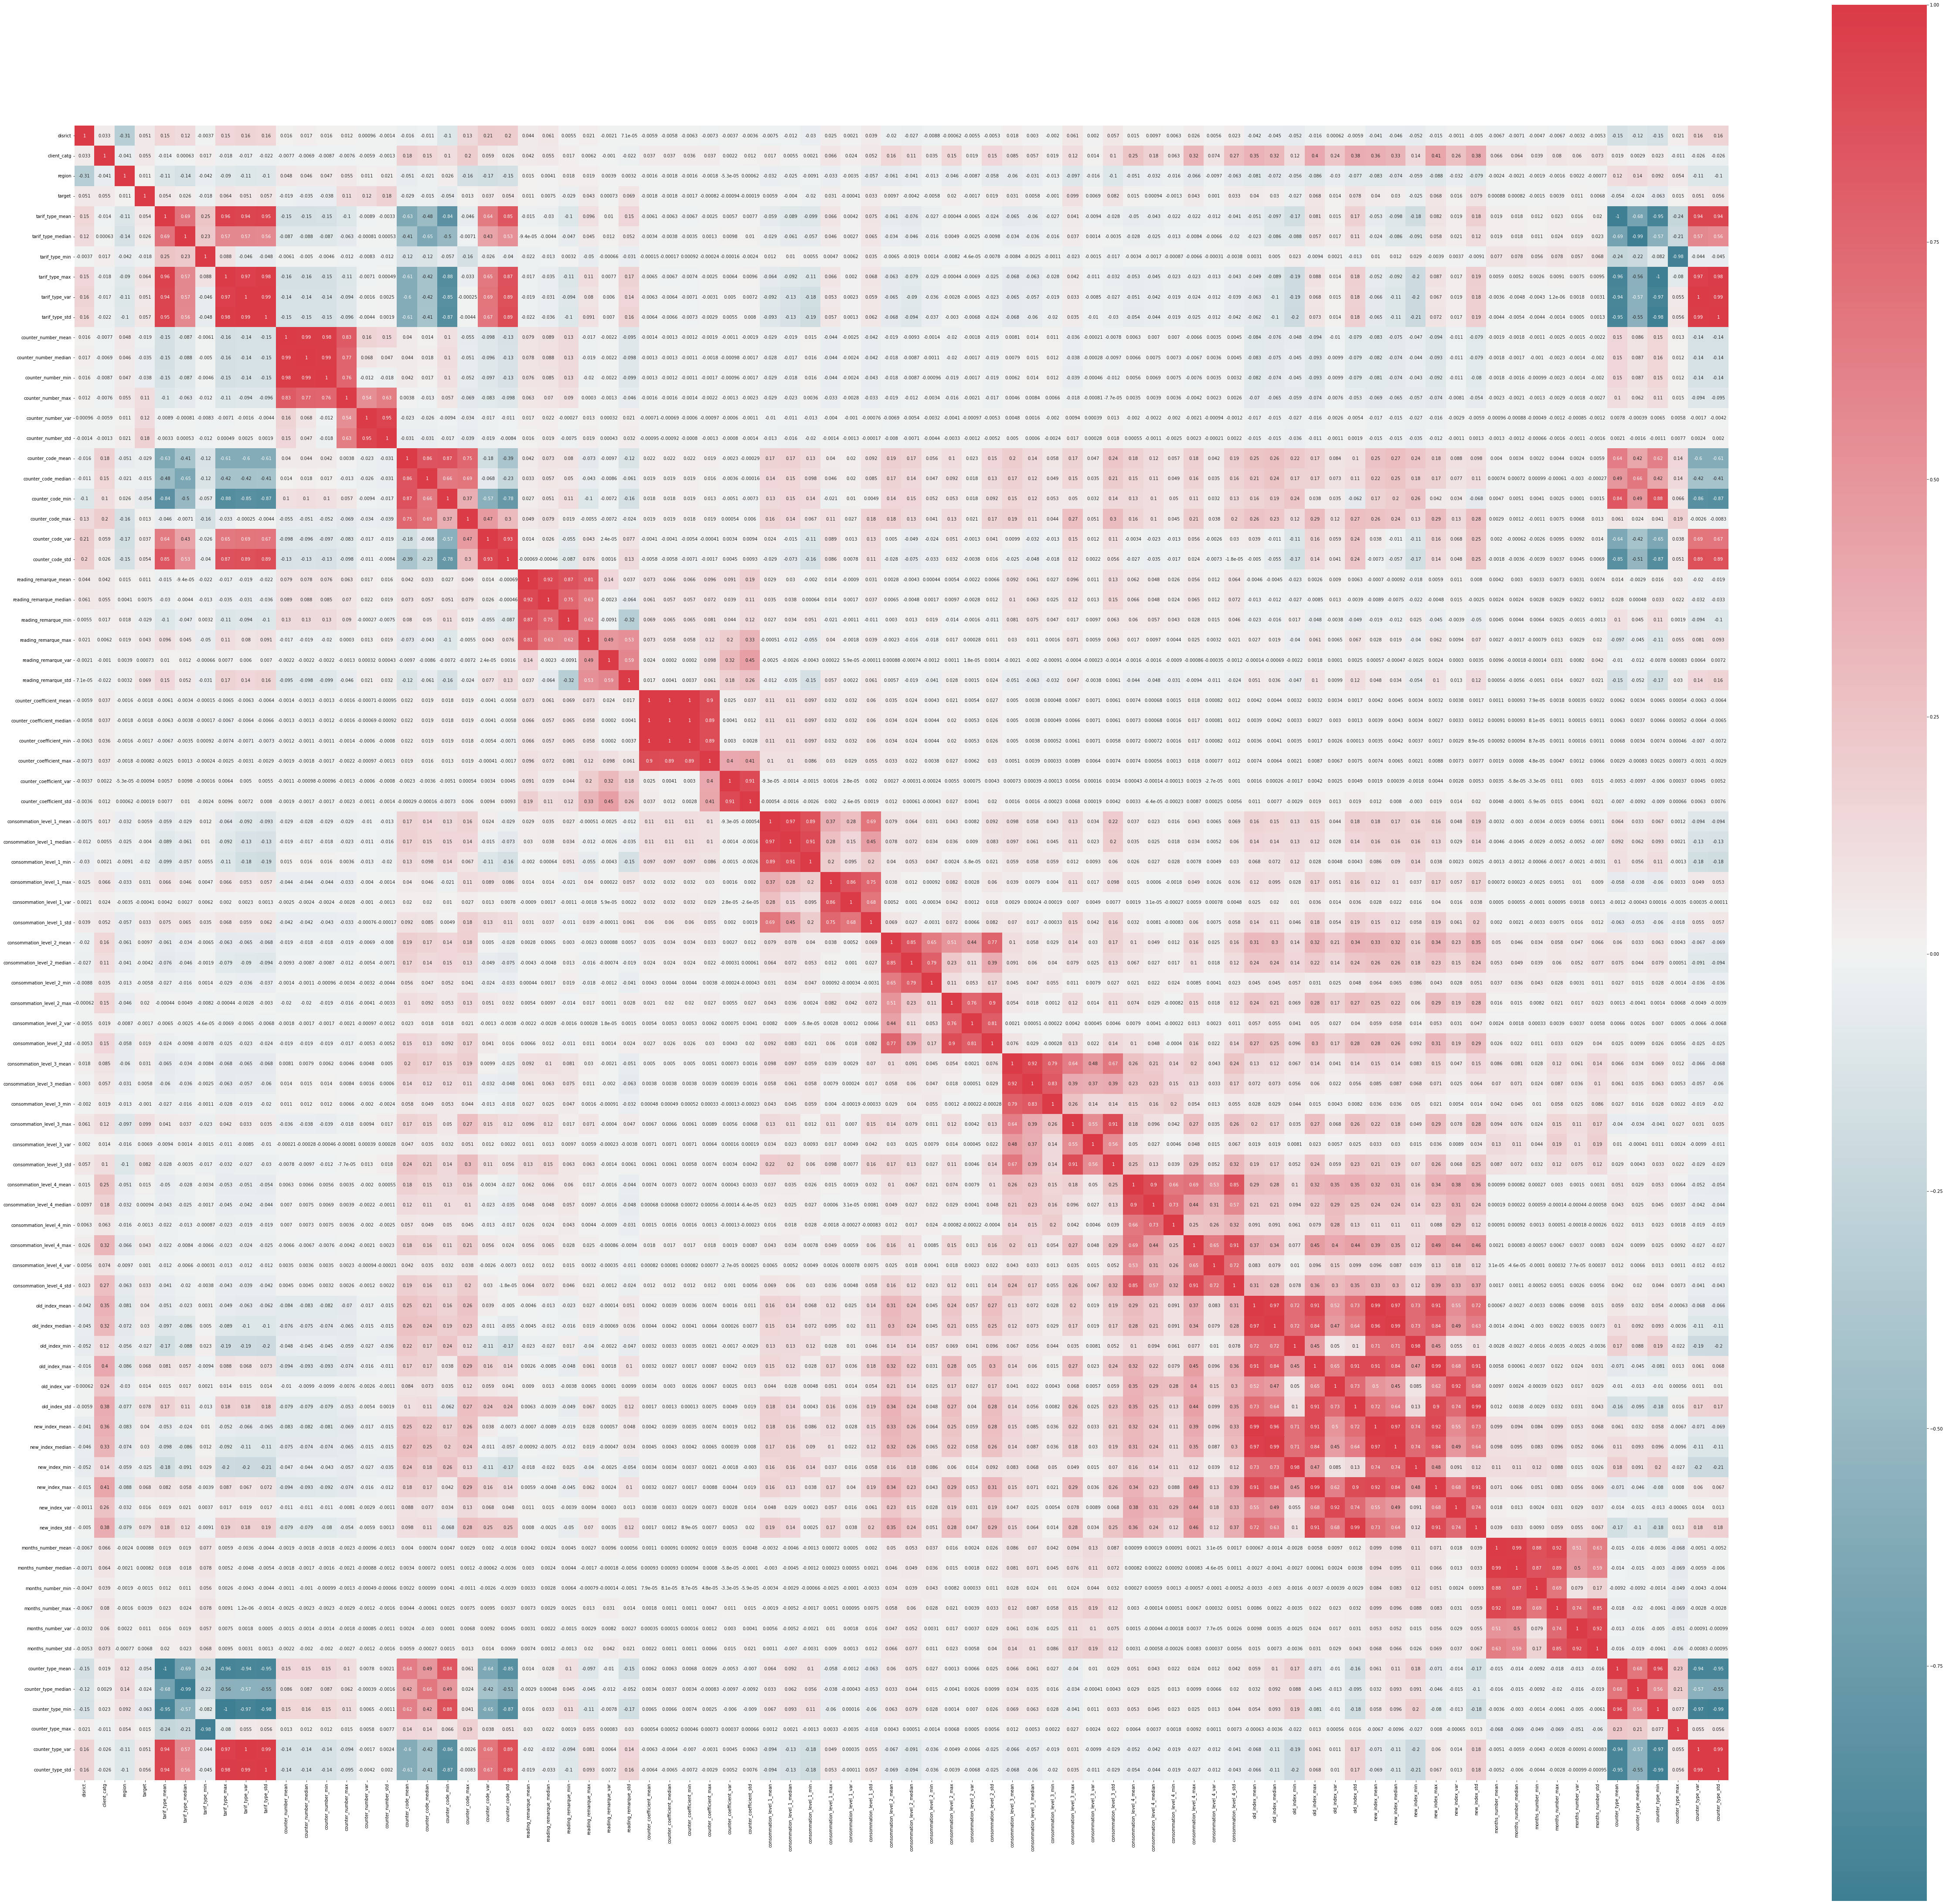

In [ ]:
# Newly Formed Training Dataset Cov HeatMap
f, ax = plt.subplots(figsize=(85, 80))
sbn.heatmap(combined_train.corr(), annot=True,
            cmap=sbn.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax)

In [ ]:
# Split Train Dataset into Features and Target
X = combined_train.drop('target',axis=1)
y = combined_train['target']

In [ ]:
#Tried Standard Scaler - better without
# ss = StandardScaler()
# X = ss.fit_transform(X)
# combined_test = ss.transform(combined_test)
# X = pd.DataFrame(X)
# combined_test = pd.DataFrame(combined_test)

In [ ]:
# Backwards Feature Elimination
# removing features with pvalues > 0.05 since this would mean they have low significance to the data
data_cols = list(X.columns)
pmax = 1
while (len(data_cols)>0):
    pvalues = []
    X_temp = X[data_cols]
    X_temp = sm.add_constant(X_temp)
    X_temp = X_temp.fillna(0)
    model = sm.OLS(y,X_temp).fit()
    pvalues = pd.Series(model.pvalues.values[1:],index = data_cols)      
    pmax = max(pvalues)
    pmax_feature = pvalues.idxmax()
    if(pmax>0.05):
        data_cols.remove(pmax_feature)
    else:
        break

#selected features
print(data_cols)

X = X[data_cols]
X.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


['disrict', 'client_catg', 'region', 'tarif_type_mean', 'tarif_type_median', 'tarif_type_min', 'tarif_type_max', 'tarif_type_var', 'tarif_type_std', 'counter_number_mean', 'counter_number_median', 'counter_number_min', 'counter_number_max', 'counter_number_var', 'counter_number_std', 'counter_code_mean', 'counter_code_median', 'counter_code_max', 'counter_code_var', 'counter_code_std', 'reading_remarque_mean', 'reading_remarque_median', 'reading_remarque_min', 'reading_remarque_max', 'reading_remarque_var', 'reading_remarque_std', 'counter_coefficient_mean', 'counter_coefficient_median', 'counter_coefficient_min', 'counter_coefficient_max', 'counter_coefficient_var', 'counter_coefficient_std', 'consommation_level_1_mean', 'consommation_level_1_median', 'consommation_level_1_min', 'consommation_level_1_max', 'consommation_level_1_var', 'consommation_level_1_std', 'consommation_level_2_mean', 'consommation_level_2_median', 'consommation_level_2_min', 'consommation_level_2_max', 'consomma

,disrict,client_catg,region,tarif_type_mean,tarif_type_median,tarif_type_min,tarif_type_max,tarif_type_var,tarif_type_std,counter_number_mean,counter_number_median,counter_number_min,counter_number_max,counter_number_var,counter_number_std,counter_code_mean,counter_code_median,counter_code_max,counter_code_var,counter_code_std,reading_remarque_mean,reading_remarque_median,reading_remarque_min,reading_remarque_max,reading_remarque_var,reading_remarque_std,counter_coefficient_mean,counter_coefficient_median,counter_coefficient_min,counter_coefficient_max,counter_coefficient_var,counter_coefficient_std,consommation_level_1_mean,consommation_level_1_median,consommation_level_1_min,consommation_level_1_max,consommation_level_1_var,consommation_level_1_std,consommation_level_2_mean,consommation_level_2_median,consommation_level_2_min,consommation_level_2_max,consommation_level_2_var,consommation_level_2_std,consommation_level_3_mean,consommation_level_3_median,consommation_level_3_min,consommation_level_3_max,consommation_level_3_var,consommation_level_3_std,consommation_level_4_mean,consommation_level_4_median,consommation_level_4_min,consommation_level_4_max,consommation_level_4_var,consommation_level_4_std,old_index_mean,old_index_median,old_index_min,old_index_max,old_index_var,old_index_std,new_index_mean,new_index_median,new_index_min,new_index_max,new_index_var,new_index_std,months_number_mean,months_number_median,months_number_min,months_number_max,months_number_var,months_number_std,counter_type_mean,counter_type_median,counter_type_min,counter_type_max,counter_type_var,counter_type_std
0,60,11,101,11.0,11.0,11,11,0.0,0.0,1335667.0,1335667.0,1335667,1335667,0.0,0.0,203.685714,203.0,207,2.339496,1.529541,6.971429,6.0,6,9,1.557983,1.248192,1.0,1.0,1,1,0.0,0.0,352.400000,267.0,38,1200,96313.070588,310.343472,10.571429,0.0,0,186,1898.252101,43.568935,0.000000,0.0,0,0,0.000000,0.000000,0.000000,0.0,0,0,0.000000,0.000000,9444.542857,7770.0,3685,16493,2.050047e+07,4527.744415,9807.514286,9156.0,3809,17078,2.097335e+07,4579.666655,4.628571,4.0,2,12,4.416807,2.101620,1.0,1.0,1,1,0.0,0.0
1,69,11,107,11.0,11.0,11,11,0.0,0.0,678902.0,678902.0,678902,678902,0.0,0.0,203.000000,203.0,203,0.000000,0.000000,7.216216,6.0,6,9,1.896396,1.377097,1.0,1.0,1,1,0.0,0.0,557.540541,520.0,190,1207,39178.644144,197.935960,0.000000,0.0,0,0,0.000000,0.000000,0.000000,0.0,0,0,0.000000,0.000000,0.000000,0.0,0,0,0.000000,0.000000,14330.756757,14232.0,4110,23940,3.750492e+07,6124.126094,14888.297297,14680.0,4661,25022,3.745102e+07,6119.723768,4.324324,4.0,2,8,1.891892,1.375461,1.0,1.0,1,1,0.0,0.0
2,62,11,301,11.0,11.0,11,11,0.0,0.0,572765.0,572765.0,572765,572765,0.0,0.0,203.222222,203.0,207,0.888889,0.942809,7.055556,6.0,6,9,1.584967,1.258955,1.0,1.0,1,1,0.0,0.0,798.611111,655.5,188,2400,264032.957516,513.841374,37.888889,0.0,0,682,25840.222222,160.748942,0.000000,0.0,0,0,0.000000,0.000000,0.000000,0.0,0,0,0.000000,0.000000,32873.000000,31469.0,25515,41532,2.827241e+07,5317.180865,33709.500000,32158.5,25974,44614,3.072740e+07,5543.230331,6.444444,4.0,4,12,11.555556,3.399346,1.0,1.0,1,1,0.0,0.0
3,69,11,105,11.0,11.0,11,11,0.0,0.0,2078.0,2078.0,2078,2078,0.0,0.0,413.000000,413.0,413,0.000000,0.000000,6.150000,6.0,6,9,0.450000,0.670820,1.0,1.0,1,1,0.0,0.0,1.200000,0.0,0,15,13.010526,3.607011,0.000000,0.0,0,0,0.000000,0.000000,0.000000,0.0,0,0,0.000000,0.000000,0.000000,0.0,0,0,0.000000,0.000000,94.150000,91.0,90,99,1.697632e+01,4.120232,95.350000,94.5,90,114,3.529211e+01,5.940716,4.200000,4.0,4,6,0.378947,0.615587,1.0,1.0,1,1,0.0,0.0
4,62,11,303,11.0,11.0,11,11,0.0,0.0,19575.0,19575.0,19575,19575,0.0,0.0,207.000000,207.0,207,0.000000,0.000000,8.857143,9.0,8,9,0.131868,0.363137,1.0,1.0,1,1,0.0,0.0,663.714286,770.0,124,800,50549.142857,224.831365,104.857143,0.0,0,400,27940.901099,167.155320,117.357143,0.0,0,800,83771.631868,289.433294,36.714286,0.0,0,382,11113.604396,105.421081,6900.428571,6989.5,0,13337,2.239288e+07,4732.111217,7823.071429,7829.5,959,13729,2.06

In [ ]:
# remove same columns from test dataset
combined_test = combined_test[data_cols]
print(len(X.columns))
print(len(combined_test.columns))

80
80


In [ ]:
#PCA - did not help much --> socred 81
# variance = 0.95
# pca = PCA(n_components = variance)
# X = X.fillna(0)
# combined_test = combined_test.fillna(0)
# X = pca.fit_transform(X)
# combined_test = pca.transform(combined_test)

# print(pca.n_components_, "principal components are needed to capture 95% of the variance in the data.")

# print('Variance per principal component: {}'.format(pca.explained_variance_ratio_))

### Model Creation

In [ ]:
seed=123

# params
param_grid = {
    'max_depth': range(10,80,1),
    'num_leaves':range(2, 500,1),
    'min_split_gain': [0.001, 0.005, 0.01],
    'n_estimators': range(0, 1000, 1),
    'learning_rate': [0.001, 0.005, 0.01],
    'feature_fraction': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10],
    'bagging_freq': [1,2,3,4,5,6,7,8,9,10],
}

# LGBM with RandomSearch
model = RandomizedSearchCV(LGBMClassifier(random_state=seed, verbosity=-1), param_grid, scoring = "roc_auc", n_jobs = -1, n_iter = 10)

stkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Utility fucntion to use KFold and perform model fit and predictions
def calc(X, y, model, cv):
    res=[]
    local_probs=pd.DataFrame()
    probs = pd.DataFrame()


    for i, (tdx, vdx) in enumerate(cv.split(X, y)):
        X_train, X_valid, y_train, y_valid = X.iloc[tdx], X.iloc[vdx], y[tdx], y[vdx]
        model.fit(X_train, y_train,
                 eval_set=[(X_train, y_train), (X_valid, y_valid)],
                 early_stopping_rounds=30, verbose=False)
        
        preds = model.predict_proba(X_valid)
        oof_predict = model.predict_proba(combined_test)
        local_probs['fold_%i'%i] = oof_predict[:,1]
        res.append(roc_auc_score(y_valid, preds[:,1]))

    print('ROC AUC:', round(np.mean(res), 6))    
    local_probs['res'] = local_probs.mean(axis=1)
    probs['target'] = local_probs['res']
    
    return probs

In [ ]:
%%time
probs = calc(X, y, model, stkfold)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


ROC AUC: 0.875996
CPU times: user 11min 33s, sys: 9.03 s, total: 11min 42s
Wall time: 2h 32min 20s


In [ ]:
# Create Submission
submission = pd.DataFrame({
        "client_id": sample_submission["client_id"],
        "target": probs['target']
    })
submission.to_csv('submission.csv', index=False)

In [ ]:
# Parameters used for best performing Model
model.best_params_

{'bagging_freq': 6,
 'feature_fraction': 0.2,
 'learning_rate': 0.01,
 'max_depth': 73,
 'min_split_gain': 0.01,
 'n_estimators': 412,
 'num_leaves': 93}

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


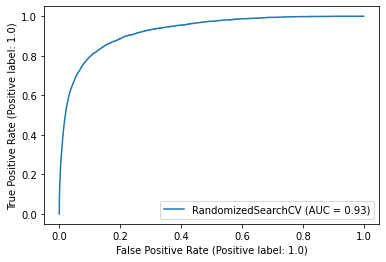

In [ ]:
# Plot ROC Curve
plot_roc_curve(model, X, y) 
plt.show()

# Other Attempts that didnt work out as well

### Attempt of Splitting Up and Aggregating Features Based on Counter Type (Elec or Gaz)

In [ ]:
# Down Sampling to work with only a piece of the dataset (10%)
client_train_first_cut, client_train_second_cut = train_test_split(client_train,train_size = .1, stratify = client_train.target, random_state = 0)

print(len(client_train_first_cut))

print(client_train_first_cut.target.value_counts())

print(client_train_second_cut.target.value_counts())

# Check to see if we got the correct invoice_train rows
invoice_train_first_cut = invoice_train[invoice_train.client_id.isin(client_train_first_cut.client_id)]


client_train_first_cut_dict = {}

for idx, client_train_first_cut_row in client_train_first_cut.iterrows():
  client_train_first_cut_dict[client_train_first_cut_row.client_id] = {};



check =  all(item in client_train_first_cut_dict.keys() for item in invoice_train_first_cut.client_id)

client_test_first_cut, client_test_second_cut = train_test_split(client_test,train_size = .1, random_state = 0)
invoice_test_first_cut = invoice_test[invoice_test.client_id.isin(client_test_first_cut.client_id)]

13549
0.0    12792
1.0      757
Name: target, dtype: int64
0.0    115135
1.0      6809
Name: target, dtype: int64


In [ ]:
client_train_first_cut.client_id

80287      train_Client_50311
70696      train_Client_41680
75976      train_Client_46432
5362      train_Client_104822
128351     train_Client_93570
                 ...         
65004      train_Client_36558
18105     train_Client_116291
130575     train_Client_95572
45971      train_Client_19428
114914     train_Client_81477
Name: client_id, Length: 13549, dtype: object

Attempting to Aggregate Invoice Dataset

In [ ]:
#keeping track of number of months a client used a counter type (elec or gas)
ranges = invoice_train_first_cut.groupby(['client_id', 'counter_type'])['months_number'].sum()
ranges = ranges.unstack(level='counter_type')
ranges = pd.DataFrame(ranges)
ranges = ranges.reset_index()
ranges_test = invoice_test.groupby(['client_id', 'counter_type'])['months_number'].sum()
ranges_test
ranges_test = ranges_test.unstack(level='counter_type')
ranges_test = pd.DataFrame(ranges_test)
ranges_test = ranges_test.reset_index()
ranges

counter_type,client_id,0,1
0,train_Client_100010,12.0,12.0
1,train_Client_100016,158.0,158.0
2,train_Client_100026,14.0,16.0
3,train_Client_100028,146.0,164.0
4,train_Client_100043,8.0,8.0
...,...,...,...
13544,train_Client_99976,80.0,168.0
13545,train_Client_99979,NaN,98.0
13546,train_Client_99994,NaN,24.0
13547,train_Client_99998,NaN,12.0


In [ ]:
# max - min of old index based on elec and gas
old_index_diffs = invoice_train_first_cut.groupby(['client_id', 'counter_type'])['old_index'].max() - invoice_train_first_cut.groupby(['client_id', 'counter_type'])['old_index'].min()
old_index_diffs = old_index_diffs.unstack(level='counter_type')
old_index_diffs = pd.DataFrame(old_index_diffs)
old_index_diffs = old_index_diffs.reset_index()
old_index_diffs

counter_type,client_id,0,1
0,train_Client_100010,47.0,830.0
1,train_Client_100016,4917.0,12263.0
2,train_Client_100026,0.0,98.0
3,train_Client_100028,9903.0,41223.0
4,train_Client_100043,7.0,30.0
...,...,...,...
13544,train_Client_99976,500.0,21871.0
13545,train_Client_99979,NaN,46995.0
13546,train_Client_99994,NaN,16.0
13547,train_Client_99998,NaN,535.0


In [ ]:
# combining months tracker with old index differences
ranges = ranges.set_index('client_id').join(old_index_diffs.set_index('client_id'),lsuffix='_total_months', rsuffix='_total_usage')
ranges = ranges.reset_index()
ranges

counter_type,client_id,0_total_months,1_total_months,0_total_usage,1_total_usage
0,train_Client_100010,12.0,12.0,47.0,830.0
1,train_Client_100016,158.0,158.0,4917.0,12263.0
2,train_Client_100026,14.0,16.0,0.0,98.0
3,train_Client_100028,146.0,164.0,9903.0,41223.0
4,train_Client_100043,8.0,8.0,7.0,30.0
...,...,...,...,...,...
13544,train_Client_99976,80.0,168.0,500.0,21871.0
13545,train_Client_99979,NaN,98.0,NaN,46995.0
13546,train_Client_99994,NaN,24.0,NaN,16.0
13547,train_Client_99998,NaN,12.0,NaN,535.0


In [ ]:
# old index difference for test dataset
old_index_diffs_test = invoice_test.groupby(['client_id', 'counter_type'])['old_index'].max() - invoice_test.groupby(['client_id', 'counter_type'])['old_index'].min()
old_index_diffs_test = old_index_diffs_test.unstack(level='counter_type')
old_index_diffs_test = pd.DataFrame(old_index_diffs_test)
old_index_diffs_test = old_index_diffs_test.reset_index()
old_index_diffs_test

counter_type,client_id,0,1
0,test_Client_0,NaN,18291.0
1,test_Client_1,NaN,55206.0
2,test_Client_10,8957.0,34419.0
3,test_Client_100,1028.0,8939.0
4,test_Client_1000,6860.0,41148.0
...,...,...,...
58064,test_Client_9995,0.0,907.0
58065,test_Client_9996,2200.0,5787.0
58066,test_Client_9997,4095.0,21987.0
58067,test_Client_9998,NaN,0.0


In [ ]:
#combine with months and index difference
ranges_test = ranges_test.set_index('client_id').join(old_index_diffs_test.set_index('client_id'),lsuffix='_total_months', rsuffix='_total_usage')
ranges_test = ranges_test.reset_index()
ranges_test

counter_type,client_id,0_total_months,1_total_months,0_total_usage,1_total_usage
0,test_Client_0,NaN,162.0,NaN,18291.0
1,test_Client_1,NaN,100.0,NaN,55206.0
2,test_Client_10,128.0,168.0,8957.0,34419.0
3,test_Client_100,78.0,78.0,1028.0,8939.0
4,test_Client_1000,84.0,156.0,6860.0,41148.0
...,...,...,...,...,...
58064,test_Client_9995,8.0,8.0,0.0,907.0
58065,test_Client_9996,96.0,98.0,2200.0,5787.0
58066,test_Client_9997,88.0,150.0,4095.0,21987.0
58067,test_Client_9998,NaN,4.0,NaN,0.0


In [ ]:
#take min reading remark feature
min_rr = invoice_train_first_cut.groupby(['client_id', 'counter_type'])['reading_remarque'].min()
min_rr = min_rr.unstack(level='counter_type')
min_rr = pd.DataFrame(min_rr)
min_rr = min_rr.reset_index()
min_rr

counter_type,client_id,0,1
0,train_Client_100010,6.0,6.0
1,train_Client_100016,6.0,6.0
2,train_Client_100026,6.0,9.0
3,train_Client_100028,6.0,6.0
4,train_Client_100043,6.0,6.0
...,...,...,...
13544,train_Client_99976,6.0,6.0
13545,train_Client_99979,NaN,6.0
13546,train_Client_99994,NaN,6.0
13547,train_Client_99998,NaN,6.0


In [ ]:
#combine reading remark with ranges dataset - train dataset
ranges = ranges.set_index('client_id').join(min_rr.set_index('client_id'),lsuffix='', rsuffix='')
ranges = ranges.reset_index()

In [ ]:
#reading remark for test - take min
min_rr_test = invoice_test.groupby(['client_id', 'counter_type'])['reading_remarque'].min()
min_rr_test = min_rr_test.unstack(level='counter_type')
min_rr_test = pd.DataFrame(min_rr_test)
min_rr_test = min_rr_test.reset_index()

In [ ]:
#combine reading remark with ranges dataset - test dataset
ranges_test = ranges_test.set_index('client_id').join(min_rr_test.set_index('client_id'),lsuffix='', rsuffix='')
ranges_test = ranges_test.reset_index()
ranges_test

counter_type,client_id,0_total_months,1_total_months,0_total_usage,1_total_usage,0,1
0,test_Client_0,NaN,162.0,NaN,18291.0,NaN,6.0
1,test_Client_1,NaN,100.0,NaN,55206.0,NaN,6.0
2,test_Client_10,128.0,168.0,8957.0,34419.0,6.0,6.0
3,test_Client_100,78.0,78.0,1028.0,8939.0,6.0,6.0
4,test_Client_1000,84.0,156.0,6860.0,41148.0,6.0,6.0
...,...,...,...,...,...,...,...
58064,test_Client_9995,8.0,8.0,0.0,907.0,6.0,6.0
58065,test_Client_9996,96.0,98.0,2200.0,5787.0,6.0,6.0
58066,test_Client_9997,88.0,150.0,4095.0,21987.0,6.0,6.0
58067,test_Client_9998,NaN,4.0,NaN,0.0,NaN,9.0


In [ ]:
#working with tarif type - train
tarif_type_unique = invoice_train_first_cut.groupby(['client_id', 'counter_type'])['tarif_type'].nunique()
tarif_type_unique = tarif_type_unique.unstack(level='counter_type')
tarif_type_unique = pd.DataFrame(tarif_type_unique)
tarif_type_unique = tarif_type_unique.reset_index()
ranges = ranges.set_index('client_id').join(tarif_type_unique.set_index('client_id'),lsuffix='_min_rr', rsuffix='_unique_tarifs')
ranges = ranges.reset_index()
ranges

counter_type,client_id,0_total_months,1_total_months,0_total_usage,1_total_usage,0_min_rr,1_min_rr,0_unique_tarifs,1_unique_tarifs
0,train_Client_100010,12.0,12.0,47.0,830.0,6.0,6.0,1.0,1.0
1,train_Client_100016,158.0,158.0,4917.0,12263.0,6.0,6.0,1.0,1.0
2,train_Client_100026,14.0,16.0,0.0,98.0,6.0,9.0,1.0,1.0
3,train_Client_100028,146.0,164.0,9903.0,41223.0,6.0,6.0,1.0,1.0
4,train_Client_100043,8.0,8.0,7.0,30.0,6.0,6.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
13544,train_Client_99976,80.0,168.0,500.0,21871.0,6.0,6.0,1.0,1.0
13545,train_Client_99979,NaN,98.0,NaN,46995.0,NaN,6.0,NaN,1.0
13546,train_Client_99994,NaN,24.0,NaN,16.0,NaN,6.0,NaN,1.0
13547,train_Client_99998,NaN,12.0,NaN,535.0,NaN,6.0,NaN,1.0


In [ ]:
# working with tarif type - test
tarif_type_unique_test = invoice_test.groupby(['client_id', 'counter_type'])['tarif_type'].nunique()
tarif_type_unique_test = tarif_type_unique_test.unstack(level='counter_type')
tarif_type_unique_test = pd.DataFrame(tarif_type_unique_test)
tarif_type_unique_test = tarif_type_unique_test.reset_index()
ranges_test = ranges_test.set_index('client_id').join(tarif_type_unique.set_index('client_id'),lsuffix='_min_rr', rsuffix='_unique_tarifs')
ranges_test = ranges_test.reset_index()
ranges_test

counter_type,client_id,0_total_months,1_total_months,0_total_usage,1_total_usage,0_min_rr,1_min_rr,0_unique_tarifs,1_unique_tarifs
0,test_Client_0,NaN,162.0,NaN,18291.0,NaN,6.0,NaN,NaN
1,test_Client_1,NaN,100.0,NaN,55206.0,NaN,6.0,NaN,NaN
2,test_Client_10,128.0,168.0,8957.0,34419.0,6.0,6.0,NaN,NaN
3,test_Client_100,78.0,78.0,1028.0,8939.0,6.0,6.0,NaN,NaN
4,test_Client_1000,84.0,156.0,6860.0,41148.0,6.0,6.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
58064,test_Client_9995,8.0,8.0,0.0,907.0,6.0,6.0,NaN,NaN
58065,test_Client_9996,96.0,98.0,2200.0,5787.0,6.0,6.0,NaN,NaN
58066,test_Client_9997,88.0,150.0,4095.0,21987.0,6.0,6.0,NaN,NaN
58067,test_Client_9998,NaN,4.0,NaN,0.0,NaN,9.0,NaN,NaN


In [ ]:
# fill in missing values
ranges['1_min_rr'] = ranges['1_min_rr'].fillna(9)
ranges['0_min_rr'] = ranges['0_min_rr'].fillna(9)
ranges = ranges.fillna(0)
ranges_test['1_min_rr'] = ranges_test['1_min_rr'].fillna(9)
ranges_test['0_min_rr'] = ranges_test['0_min_rr'].fillna(9)
ranges_test = ranges_test.fillna(0)

In [ ]:
#combine client train and new invoice train dataframes
final_dataset = client_train.set_index('client_id').join(ranges.set_index('client_id'))
final_dataset = final_dataset.reset_index()
final_dataset = final_dataset.reindex(index=order_by_index(final_dataset.index, index_natsorted(final_dataset.client_id)))
final_dataset = final_dataset.reset_index(drop=True)
final_dataset

,client_id,disrict,client_catg,region,creation_date,target,0_total_months,1_total_months,0_total_usage,1_total_usage,0_min_rr,1_min_rr,0_unique_tarifs,1_unique_tarifs
0,train_Client_0,60,11,101,31/12/1994,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,train_Client_1,69,11,107,29/05/2002,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,train_Client_2,60,11,101,18/06/2004,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,train_Client_3,62,11,303,18/12/2002,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,train_Client_4,69,11,104,10/02/2009,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135488,train_Client_135488,63,11,101,08/12/2015,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135489,train_Client_135489,69,12,104,18/07/2011,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135490,train_Client_135490,62,11,302,24/12/1997,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135491,train_Client_135491,62,11,301,10/04/2009,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#combine client test and new invoice test dataframes
final_testset = client_test.set_index('client_id').join(ranges_test.set_index('client_id'))
final_testset = final_testset.reset_index()
final_testset = final_testset.reindex(index=order_by_index(final_dataset.index, index_natsorted(final_dataset.client_id)))
final_testset = final_testset.reset_index(drop=True)
final_testset.dropna(axis = 0, how = 'all', inplace = True)
final_testset = final_testset.drop(columns = 'creation_date')
final_indexes = final_testset['client_id']
final_testset = final_testset.set_index('client_id')
final_testset

,disrict,client_catg,region,0_total_months,1_total_months,0_total_usage,1_total_usage,0_min_rr,1_min_rr,0_unique_tarifs,1_unique_tarifs
client_id,,,,,,,,,,,
test_Client_0,62.0,11.0,307.0,0.0,162.0,0.0,18291.0,9.0,6.0,0.0,0.0
test_Client_1,69.0,11.0,103.0,0.0,100.0,0.0,55206.0,9.0,6.0,0.0,0.0
test_Client_10,62.0,11.0,310.0,128.0,168.0,8957.0,34419.0,6.0,6.0,0.0,0.0
test_Client_100,60.0,11.0,101.0,78.0,78.0,1028.0,8939.0,6.0,6.0,0.0,0.0
test_Client_1000,62.0,11.0,301.0,84.0,156.0,6860.0,41148.0,6.0,6.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
test_Client_9995,63.0,11.0,399.0,8.0,8.0,0.0,907.0,6.0,6.0,0.0,0.0
test_Client_9996,63.0,11.0,311.0,96.0,98.0,2200.0,5787.0,6.0,6.0,0.0,0.0
test_Client_9997,60.0,11.0,101.0,88.0,150.0,4095.0,21987.0,6.0,6.0,0.0,0.0


In [ ]:
%%time
model_dataset = final_dataset.drop(columns = ['client_id', 'creation_date'])

parameters_LGBM = SEARCH_PARAMS = {'learning_rate': [0.4, 0.6, 0.8, 1.0],
                 'max_depth': [15, 12, 9, 6, 3],
                 'num_leaves': [3, 5, 8, 11, 12, 15],
                 'feature_fraction': [0.8, 0.6, 0.7, 0.5],
                 'subsample':[0.3, 0.4, 0.1, 0.2]}

X_train, X_test, y_train, y_test = train_test_split(model_dataset, model_dataset.target, test_size = .3, stratify = model_dataset.target, random_state = 0)

#set the minority class to a seperate dataframe
one_df = X_train[X_train['target'] == 1]

#set other classes to another dataframe
other_df = X_train[X_train['target'] != 1]  


#ATTEMPTED UPSAMPLING - DIDNT FIND SIGNIFICANCE RESULTS
#upsample the minority class
df_1_upsampled = resample(one_df,random_state=42,n_samples = 5000,replace=True)
#concatenate the upsampled dataframe
df_upsampled = pd.concat([df_1_upsampled,other_df])
df_upsampled
y_train = df_upsampled['target']
X_train = df_upsampled.loc[:, df_upsampled.columns != 'target']
X_test = X_test.loc[:, X_test.columns != 'target']
X_test.head()

clf = RandomizedSearchCV(LGBMClassifier(), parameters_LGBM, scoring = "roc_auc", n_jobs = 8, n_iter = 100)

clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
print(score)

0.594643056789832
CPU times: user 8.6 s, sys: 1.19 s, total: 9.79 s
Wall time: 4min


### Attempt Using Featuretools to Automate Feature aggregation of Invoice Dataset

In [ ]:
# Automation Feature Engineering But With PCA

pd.set_option('display.max_rows', 120)
agg_primitives = ['mean', 'entropy', 'std', 'skew', 'last', 'max', 'min']

# Create new entityset
es = ft.EntitySet(id = 'clients')

merged_w_client_dataset = pd.merge(client_train_first_cut, final_dataset, on="client_id")

# Create an entity from the client dataframe
# This dataframe already has an index and a time index
es = es.add_dataframe(
    dataframe_name = 'invoice_train', 
    dataframe = invoice_train_first_cut, # change to invoice_train_first_cut for faster processing and invoice_train for actual
    index = 'invoice_id', 
)

es = es.add_dataframe(
    dataframe_name = 'client_train', 
    dataframe = merged_w_client_dataset, # change to client_train_first_cut for faster processing and client_train for actual
    index = 'client_id', 
)

r_client_previous = ft.Relationship(es,'client_train','client_id','invoice_train','client_id')

# Add the relationship to the entity set
es = es.add_relationships([r_client_previous])

excluded_features_for_train = ['LAST(invoice_train.counter_type)', 'MONTH(creation_date_x)', 'MONTH(creation_date_y)', 'LAST(invoice_train.counter_statue)','disrict_x', 'client_catg_x', 'region_x','disrict_y', 'client_catg_y', 'region_y', 'target_y']


# Feature engineer using the training data using different primitives
feature_matrix, feature_defs  = ft.dfs(max_depth = 80, target_dataframe_name='client_train', entityset = es, agg_primitives = agg_primitives, trans_primitives=["month"])
feature_matrix = feature_matrix.rename(columns={'target_x':'target'})
feature_matrix = feature_matrix.drop(columns=excluded_features_for_train)

X_train = feature_matrix;
y_train = feature_matrix['target']

# Pre-processing
X_train['LAST(invoice_train.MONTH(invoice_date))'] = X_train['LAST(invoice_train.MONTH(invoice_date))'].astype('int')
X_train['MONTH(LAST(invoice_train.invoice_date))'] = X_train['MONTH(LAST(invoice_train.invoice_date))'].astype('int')
print(X_train.select_dtypes(include=['category']).columns)
X_train = X_train.fillna(0)

# dimentionality reduction
pca = PCA(n_components=.95, random_state=0)
X_train = pca.fit_transform(X_train)

clf = RandomizedSearchCV(LGBMClassifier(), parameters_LGBM, scoring = "roc_auc", n_jobs = 8, n_iter = 100)

clf.fit(X_train, y_train)

# score = clf.score(X_test, y_test)

# print(score)

merged_w_client_test = pd.merge(client_test, final_testset, on="client_id")

# Create test set
es = ft.EntitySet(id = 'clients')
es = es.add_dataframe(
    dataframe_name = 'invoice_test', 
    dataframe = invoice_test, 
    index = 'invoice_id', 
)

es = es.add_dataframe(
    dataframe_name = 'client_test', 
    dataframe = merged_w_client_test, 
    index = 'client_id', 
)

r_client_previous = ft.Relationship(es,'client_test','client_id','invoice_test','client_id')

# Add the relationship to the entity set
es = es.add_relationships([r_client_previous])

excluded_features_for_test = ['disrict', 'client_catg', 'region']

# Feature engineer using the testing data using the same primitives so we can use the resulting attribute values to test our model
feature_matrix, feature_defs  = ft.dfs(max_depth = 80, target_dataframe_name='client_test', entityset = es, agg_primitives = agg_primitives, trans_primitives=["month"])
feature_matrix['LAST(invoice_test.MONTH(invoice_date))'] = feature_matrix['LAST(invoice_test.MONTH(invoice_date))'].astype('int')
feature_matrix['MONTH(LAST(invoice_test.invoice_date))'] = feature_matrix['MONTH(LAST(invoice_test.invoice_date))'].astype('int')
feature_matrix['MONTH(creation_date)'] = feature_matrix['MONTH(creation_date)'].astype('int')
feature_matrix = feature_matrix.drop(columns=[]).fillna(0)

# dimentionality reduction
X_test_new = pca.fit_transform(feature_matrix)


output = clf.predict(X_test_new)

indexes = feature_matrix.loc[:, feature_matrix.columns == 'client_id'].reset_index(drop=False)
output = pd.DataFrame(output).rename(columns={"0": "target",})
submission = indexes.join(output)
compression_opts = dict(method='zip',
                        archive_name='out.csv')  
submission.to_csv('out.zip', index=False,
          compression=compression_opts)


#Score: 0.50